In [20]:
import numpy as np
import spiceypy as spice
from lamberthub import izzo2015    # pip install lamberthub
from scipy.optimize import differential_evolution

# -----------------------------------------------------------
# 1. SPICE setup
# -----------------------------------------------------------
# Change these paths to where your kernels live
spice.furnsh("/Users/rebnoob/Documents/ae105/generic_kernels/lsk/naif0012.tls")
spice.furnsh("/Users/rebnoob/Documents/ae105/generic_kernels/spk/planets/de442.bsp")
spice.furnsh("/Users/rebnoob/Documents/ae105/generic_kernels/spk/vgr2.x2100.bsp")

# -----------------------------------------------------------
# 2. Constants (hardcoded GMs so we don't call bodvrd)
# -----------------------------------------------------------
# from NAIF (km^3/s^2)
MU_SUN   = 132712440041.279
MU_EARTH = 398600.435436     # Earth system, good enough
MU_MARS  = 42828.375214

R_EARTH = 6378.1363  # km
R_MARS  = 3396.19    # km

h_park_earth = 200.0
h_park_mars  = 200.0

r_park_earth = R_EARTH + h_park_earth
r_park_mars  = R_MARS  + h_park_mars

def dv_escape_from_circ(v_inf, mu_body, r_circ):
    v_circ = np.sqrt(mu_body / r_circ)
    v_esc  = np.sqrt(2.0 * mu_body / r_circ)
    v_peri_hyp = np.sqrt(v_inf**2 + v_esc**2)
    return v_peri_hyp - v_circ

def dv_capture_to_circ(v_inf, mu_body, r_circ):
    v_circ = np.sqrt(mu_body / r_circ)
    v_peri_hyp = np.sqrt(v_inf**2 + 2.0 * mu_body / r_circ)
    return v_peri_hyp - v_circ

def sun_state(body, et):
    # heliocentric state in ECLIPJ2000
    st, _ = spice.spkezr(body, et, "ECLIPJ2000", "NONE", "SUN")
    r = np.array(st[0:3])
    v = np.array(st[3:6])
    return r, v

# -----------------------------------------------------------
# merit function
# -----------------------------------------------------------
def total_dv(x):
    t0  = x[0]
    tof = x[1]
    t1  = t0 + tof

    r_e, v_e = sun_state("EARTH Barycenter", t0)
    r_m, v_m = sun_state("MARS Barycenter",  t1)

    # lambert
    v1, v2 = izzo2015(MU_SUN, r_e, r_m, tof, M=0, prograde=True)

    v_inf_dep = np.linalg.norm(v1 - v_e)
    v_inf_arr = np.linalg.norm(v2 - v_m)

    dv0 = dv_escape_from_circ(v_inf_dep, MU_EARTH, r_park_earth)
    dv1 = dv_capture_to_circ(v_inf_arr, MU_MARS,  r_park_mars)

    return dv0 + dv1

# -----------------------------------------------------------
# 4. optimize over window
# -----------------------------------------------------------
t0_min = spice.str2et("2035 JAN 01")
t0_max = spice.str2et("2037 JAN 01")

tof_min = 100.0 * 86400.0
tof_max = 400.0 * 86400.0

bounds = [(t0_min, t0_max), (tof_min, tof_max)]

result = differential_evolution(
    total_dv,
    bounds,
    tol=1e-4,
    maxiter=80,
    polish=True,
)

best_t0  = result.x[0]
best_tof = result.x[1]
best_t1  = best_t0 + best_tof

print("Min DV (km/s):", result.fun)
print("Best departure (TDB):", spice.et2utc(best_t0, "C", 0))
print("Best arrival   (TDB):", spice.et2utc(best_t1, "C", 0))
print("TOF (days):", best_tof / 86400.0)

Min DV (km/s): 5.7791931192082515
Best departure (TDB): 2035 JUN 27 14:18:36
Best arrival   (TDB): 2036 JAN 15 11:45:52
TOF (days): 201.8939311510428


2035 JAN 01 00:00:00  minDV=8.890 km/s  TOF=258.1 days
2035 JAN 02 00:00:00  minDV=8.867 km/s  TOF=257.9 days
2035 JAN 03 00:00:00  minDV=8.844 km/s  TOF=257.8 days
2035 JAN 04 00:00:00  minDV=8.821 km/s  TOF=257.6 days
2035 JAN 05 00:00:00  minDV=8.798 km/s  TOF=257.5 days
2035 JAN 06 00:00:00  minDV=8.776 km/s  TOF=257.3 days
2035 JAN 07 00:00:00  minDV=8.753 km/s  TOF=257.2 days
2035 JAN 08 00:00:00  minDV=8.730 km/s  TOF=257.0 days
2035 JAN 09 00:00:00  minDV=8.708 km/s  TOF=256.8 days
2035 JAN 10 00:00:00  minDV=8.686 km/s  TOF=256.7 days
2035 JAN 11 00:00:00  minDV=8.663 km/s  TOF=256.5 days
2035 JAN 12 00:00:00  minDV=8.641 km/s  TOF=256.4 days
2035 JAN 13 00:00:00  minDV=8.619 km/s  TOF=256.2 days
2035 JAN 14 00:00:00  minDV=8.597 km/s  TOF=256.1 days
2035 JAN 15 00:00:00  minDV=8.576 km/s  TOF=255.9 days
2035 JAN 16 00:00:00  minDV=8.554 km/s  TOF=255.7 days
2035 JAN 17 00:00:00  minDV=8.532 km/s  TOF=255.6 days
2035 JAN 18 00:00:00  minDV=8.510 km/s  TOF=255.4 days
2035 JAN 1

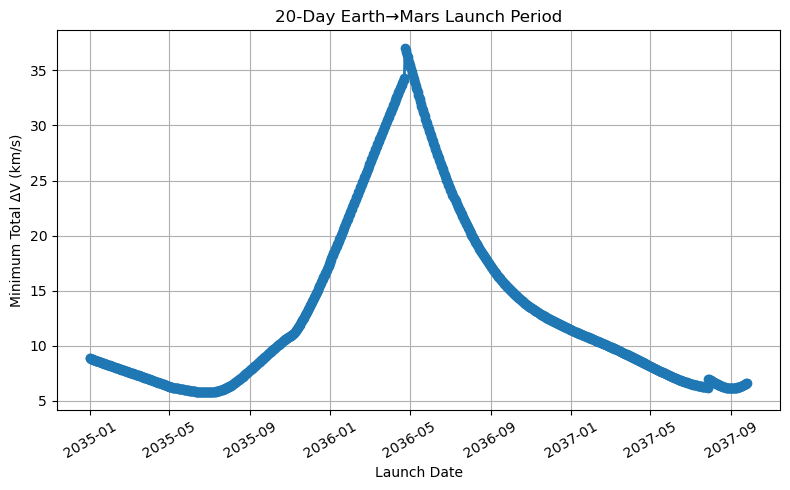

In [17]:
import numpy as np
import spiceypy as spice
from lamberthub import izzo2015
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt


# === Constants ===
MU_SUN   = 132712440041.279
MU_EARTH = 398600.435436
MU_MARS  = 42828.375214
R_EARTH  = 6378.1363
R_MARS   = 3396.19
r_park_earth = R_EARTH + 200.0
r_park_mars  = R_MARS  + 200.0

def dv_escape_from_circ(v_inf, mu_body, r_circ):
    v_circ = np.sqrt(mu_body / r_circ)
    v_esc  = np.sqrt(2.0 * mu_body / r_circ)
    v_peri = np.sqrt(v_inf**2 + v_esc**2)
    return v_peri - v_circ

def dv_capture_to_circ(v_inf, mu_body, r_circ):
    v_circ = np.sqrt(mu_body / r_circ)
    v_peri = np.sqrt(v_inf**2 + 2.0 * mu_body / r_circ)
    return v_peri - v_circ

def sun_state(body, et):
    s, _ = spice.spkezr(body, et, "ECLIPJ2000", "NONE", "SUN")
    return np.array(s[:3]), np.array(s[3:6])

def total_dv_fixed_t0(t0, tof):
    t1 = t0 + tof
    r_e, v_e = sun_state("EARTH Barycenter", t0)
    r_m, v_m = sun_state("MARS Barycenter",  t1)
    v1, v2 = izzo2015(MU_SUN, r_e, r_m, tof, M=0, prograde=True)
    v_inf_dep = np.linalg.norm(v1 - v_e)
    v_inf_arr = np.linalg.norm(v2 - v_m)
    dv0 = dv_escape_from_circ(v_inf_dep, MU_EARTH, r_park_earth)
    dv1 = dv_capture_to_circ(v_inf_arr, MU_MARS,  r_park_mars)
    return dv0 + dv1

# === Parameters for 20-day sweep ===
start_date = "2035 JAN 01"
t0_start = spice.str2et(start_date)
num_days = 1000
step_days = 1  # step size for sampling

t0_list = [t0_start + i * 86400.0 * step_days for i in range(num_days)]
dv_min_list = []
tof_opt_list = []

# === Optimization bounds for time of flight ===
tof_bounds = (100.0 * 86400.0, 400.0 * 86400.0)

for t0 in t0_list:
    # Optimize only over TOF for each fixed t0
    res = minimize_scalar(
        lambda tof: total_dv_fixed_t0(t0, tof),
        bounds=tof_bounds,
        method='bounded',
        options={'xatol': 1.0}
    )
    dv_min_list.append(res.fun)
    tof_opt_list.append(res.x / 86400.0)  # days
    print(f"{spice.et2utc(t0, 'C', 0)}  minDV={res.fun:.3f} km/s  TOF={res.x/86400:.1f} days")

# === Plot the launch period curve ===
dates = [spice.et2datetime(t).date() for t in t0_list]
plt.figure(figsize=(8,5))
plt.plot(dates, dv_min_list, 'o-', lw=2)
plt.xlabel("Launch Date")
plt.ylabel("Minimum Total ΔV (km/s)")
plt.title("20-Day Earth→Mars Launch Period")
plt.grid(True)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

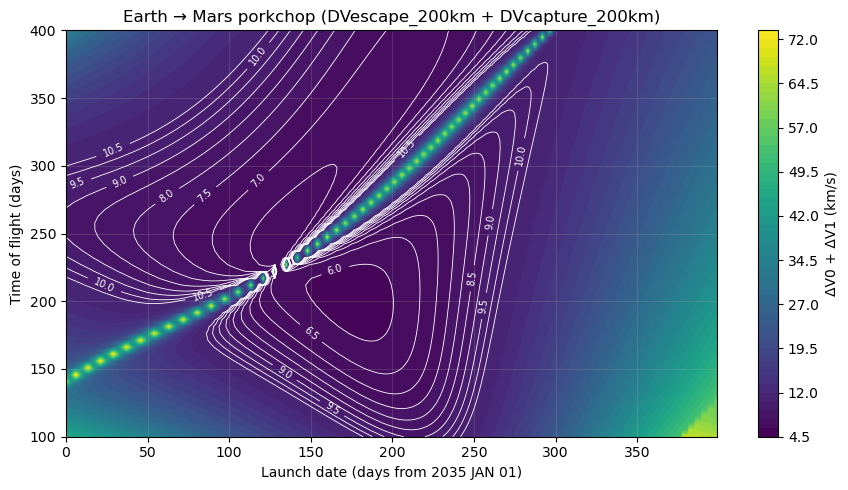

In [19]:
import numpy as np
import spiceypy as spice
from lamberthub import izzo2015
import matplotlib.pyplot as plt


MU_SUN   = 132712440041.279  # km^3/s^2
MU_EARTH = 398600.435436
MU_MARS  = 42828.375214

R_EARTH = 6378.1363
R_MARS  = 3396.19
r_park_earth = R_EARTH + 200.0
r_park_mars  = R_MARS  + 200.0

def dv_escape_from_circ(v_inf, mu_body, r_circ):
    v_circ = np.sqrt(mu_body / r_circ)
    v_esc  = np.sqrt(2.0 * mu_body / r_circ)
    v_peri = np.sqrt(v_inf**2 + v_esc**2)
    return v_peri - v_circ

def dv_capture_to_circ(v_inf, mu_body, r_circ):
    v_circ = np.sqrt(mu_body / r_circ)
    v_peri = np.sqrt(v_inf**2 + 2.0 * mu_body / r_circ)
    return v_peri - v_circ

def sun_state(body, et):
    s, _ = spice.spkezr(body, et, "ECLIPJ2000", "NONE", "SUN")
    return np.array(s[:3]), np.array(s[3:6])

# ==============================
# 2. Define grid
# ==============================
# 20-day launch period
start_date_str = "2035 JAN 01"
t0_start = spice.str2et(start_date_str)

num_t0 = 400           # 20 days
num_tof = 60          # say 60 TOF samples
t0_vec = t0_start + np.arange(num_t0) * 86400.0   # 1-day step

tof_min = 100.0 * 86400.0
tof_max = 400.0 * 86400.0
tof_vec = np.linspace(tof_min, tof_max, num_tof)

# mesh
T0, TOF = np.meshgrid(t0_vec, tof_vec, indexing='xy')  # shape (num_tof, num_t0)

DVtot = np.full_like(T0, np.nan, dtype=float)

# ==============================
# 3. Fill grid
# ==============================
for j in range(num_t0):
    t0 = t0_vec[j]
    # prefetch Earth state at this departure
    r_e, v_e = sun_state("EARTH Barycenter", t0)
    for i in range(num_tof):
        tof = tof_vec[i]
        t1 = t0 + tof
        # Mars state
        r_m, v_m = sun_state("MARS Barycenter", t1)
        try:
            v1, v2 = izzo2015(MU_SUN, r_e, r_m, tof, M=0, prograde=True)
        except Exception:
            # some geometries might fail
            continue
        v_inf_dep = np.linalg.norm(v1 - v_e)
        v_inf_arr = np.linalg.norm(v2 - v_m)
        dv0 = dv_escape_from_circ(v_inf_dep, MU_EARTH, r_park_earth)
        dv1 = dv_capture_to_circ(v_inf_arr, MU_MARS,  r_park_mars)
        DVtot[i, j] = dv0 + dv1

# ==============================
# 4. Plot porkchop
# ==============================
# x-axis: launch date (days from start)
# y-axis: TOF (days)
X = (T0 - t0_start) / 86400.0   # days after start
Y = TOF / 86400.0

plt.figure(figsize=(9, 5))
# pick some nice levels (tune these after you see the range)
valid = np.isfinite(DVtot)
dvmin = np.nanmin(DVtot)
dvmax = np.nanmax(DVtot)
# make levels every 0.5 km/s around min
base = np.floor(dvmin * 2) / 2.0
levels = np.arange(base, min(dvmin + 5.0, dvmax + 0.5), 0.5)

cf = plt.contourf(X, Y, DVtot, levels=50, cmap='viridis')
cbar = plt.colorbar(cf, label="ΔV0 + ΔV1 (km/s)")

# overlay contour lines at nice round values
cs = plt.contour(X, Y, DVtot, levels=levels, colors='white', linewidths=0.6)
plt.clabel(cs, inline=True, fontsize=7, fmt="%.1f")

plt.xlabel(f"Launch date (days from {start_date_str})")
plt.ylabel("Time of flight (days)")
plt.title("Earth → Mars porkchop (DVescape_200km + DVcapture_200km)")
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()